<a href="https://colab.research.google.com/github/harshitha13732/Optimization-Model/blob/main/Optimization_model_(Task_4)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import & Installing


In [1]:
import importlib, subprocess, sys
def install_if_missing(pkg_name, import_name=None):
  module = import_name or pkg_name
  try:
    importlib.import_module(module)
  except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])

In [2]:
install_if_missing('pulp')
import pandas as pd
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, PULP_CBC_CMD, LpStatus, value, LpInteger

# Problem def % Tidy Data


In [3]:
products = ["Bread", "Cake", "Pastry"]

params = pd.DataFrame({
    "product": products,
    "profit": [5.0, 8.0, 6.0],
    "labour_hours": [0.5, 1.0, 0.7],
    "oven_hours": [0.2, 0.5, 0.3],
    "flour_kg": [0.3, 0.7, 0.4],
    "demand_max": [200, 80, 150]
})
capacities = {"labour_hours": 100, "oven_hours": 50, "flour_kg":60}

# Building solve_bakery_lp
# Running the continuous LP & Interpreting results

In [6]:
model_cont, vars_cont, obj_cont, status_cont, results_cont_df = solve_bakery_lp(params, capacities, integer=False)

In [5]:
def solve_bakery_lp(params, capacities, integer=True):
    """
    Solves the bakery production linear programming problem.

    Args:
        params (pd.DataFrame): DataFrame containing product parameters.
        capacities (dict): Dictionary of resource capacities.
        integer (bool): Whether to use integer variables (for IP) or continuous variables (for LP).

    Returns:
        tuple: A tuple containing:
            - model (LpProblem): The solved PuLP model.
            - vars (dict): A dictionary of the decision variables.
            - obj (float or None): The optimal objective value (total profit), or None if not optimal.
            - status (str): The status of the solution.
            - results_df (pd.DataFrame): DataFrame summarizing the production results.
    """
    model = LpProblem("Bakery_Production", LpMaximize) # model creation

    cat = LpInteger if integer else None
    vars = {}
    products = params["product"].tolist()
    for p in products:
        ub = float(params.loc[params["product"] == p, "demand_max"].iloc[0])
        vars[p] = LpVariable(f"prod_{p}", lowBound=0, upBound=ub, cat=cat)

    # Objective
    profit_expr = lpSum([vars[p] * float(params.loc[params["product"] == p, "profit"].iloc[0])
      for p in products])
    model += profit_expr, "Total_profit"

    # Constraints (resource limits)
    model += lpSum([vars[p] * float(params.loc[params["product"] == p, "labour_hours"].iloc[0]) for p in products]) <= capacities["labour_hours"], "Labour_Limit"
    model += lpSum([vars[p] * float(params.loc[params["product"] == p, "oven_hours"].iloc[0]) for p in products]) <= capacities["oven_hours"], "Oven_Limit"
    model += lpSum([vars[p] * float(params.loc[params["product"] == p, "flour_kg"].iloc[0]) for p in products]) <= capacities["flour_kg"], "Flour_Limit"

    # solve
    solver_msg = False
    solver = PULP_CBC_CMD(msg=solver_msg)
    model.solve(solver)

    # Results Extraction
    status = LpStatus[model.status]
    obj = None  # Initialize objective to None
    results = []

    if model.status == 1:  # Check if the solution status is Optimal
        obj = value(model.objective)
        for p in products:
            val = vars[p].varValue
            profit_contrib = val * float(params.loc[params["product"] == p, "profit"].iloc[0])
            results.append({"Product": p, "Optimal Value": val, "Profit Contribution": profit_contrib})
    else:
        # If not optimal, populate results_df with default values or indicators
        for p in products:
             results.append({"Product": p, "Optimal Value": None, "Profit Contribution": None})


    results_df = pd.DataFrame(results)

    return model, vars, obj, status, results_df

In [7]:
# Solve the integer programming problem using the defined function
model_int, vars_int, obj_int, status_int, results_int_df = solve_bakery_lp(params, capacities, integer=True)

# Display the results for the integer programming problem
print("Integer Programming Results:")
print("Status:", status_int)
print("Total Profit:", obj_int)
display(results_int_df)

Integer Programming Results:
Status: Optimal
Total Profit: 1000.0


,Product,Optimal Value,Profit Contribution
0,Bread,200.0,1000.0
1,Cake,0.0,0.0
2,Pastry,0.0,0.0


# Visualize & Export results

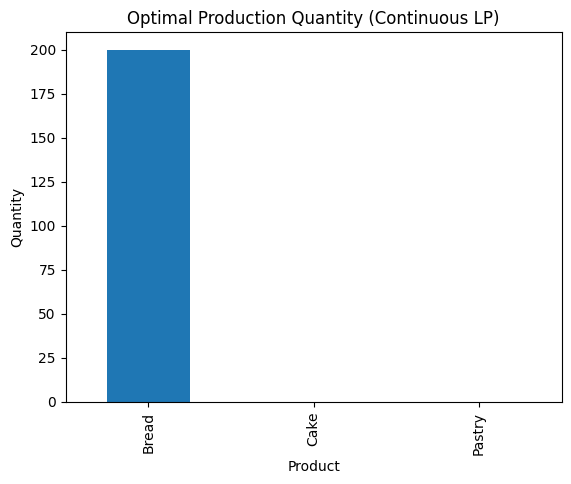

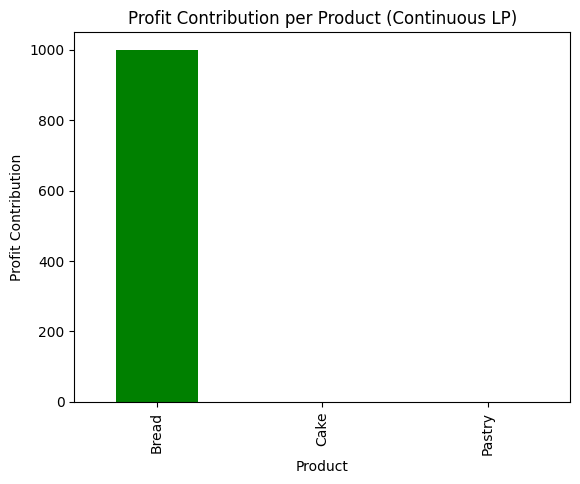

In [8]:
results_cont_df.plot(kind='bar', x='Product', y='Optimal Value', legend=False)
plt.title('Optimal Production Quantity (Continuous LP)')
plt.ylabel('Quantity')
plt.xlabel('Product')
plt.show()

results_cont_df.plot(kind='bar', x='Product', y='Profit Contribution', legend=False, color='green')
plt.title('Profit Contribution per Product (Continuous LP)')
plt.ylabel('Profit Contribution')
plt.xlabel('Product')
plt.show()

In [ ]:
# Export
results_cont_df.to_csv('bakery_results_continuous.csv', index=False)

# Integer (MIP) sol & comparision

In [9]:
model_int, vars_int, obj_int, status_int, results_int_df = solve_bakery_lp(params, capacities, integer=True)

# Sensitivity analysis

In [10]:
# Define the range for labour hours sensitivity analysis
labour_range = range(80, 121, 5) # Example range: from 80 to 120 in steps of 5

# Define base capacities
base_capacities = capacities.copy()

objs = []
for cap in labour_range:
  caps = base_capacities.copy()
  caps['labour_hours'] = cap
  _, _, obj_val, _, _ = solve_bakery_lp(params, caps, integer= False)
  objs.append(obj_val)

# Report & resource usage

In [11]:
# Calculate resource usage based on continuous LP results
usage = {}
labour_used = 0
oven_used = 0
flour_used = 0

for index, row in results_cont_df.iterrows():
    product = row['Product']
    optimal_value = row['Optimal Value']

    # Find the corresponding parameters for the product
    param_row = params[params['product'] == product].iloc[0]

    labour_used += param_row['labour_hours'] * optimal_value
    oven_used += param_row['oven_hours'] * optimal_value
    flour_used += param_row['flour_kg'] * optimal_value

usage['labour_used'] = labour_used
usage['oven_used'] = oven_used
usage['flour_used'] = flour_used


# Calculate slack for labour hours
slack = capacities['labour_hours'] - usage['labour_used']

# You can calculate slack for other resources similarly
# slack_oven = capacities['oven_hours'] - usage['oven_used']
# slack_flour = capacities['flour_kg'] - usage['flour_used']

print("Resource Usage (Continuous LP):")
print(f"Labour Used: {usage['labour_used']:.2f} out of {capacities['labour_hours']}")
print(f"Labour Slack: {slack:.2f}")

# You can print usage and slack for other resources here
# print(f"Oven Used: {usage['oven_used']:.2f} out of {capacities['oven_hours']}")
# print(f"Oven Slack: {slack_oven:.2f}")
# print(f"Flour Used: {usage['flour_used']:.2f} out of {capacities['flour_kg']}")
# print(f"Flour Slack: {slack_flour:.2f}")

Resource Usage (Continuous LP):
Labour Used: 100.00 out of 100
Labour Slack: 0.00
